# Daily climate time series

### import the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings('ignore')
%matplotlib inline


### Load the dataset

In [2]:
df = pd.read_csv('DailyDelhiClimateTrain.csv',header= 0)
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


### EDA

#### 1.Shape of the data

In [3]:
df.shape

(1462, 5)

#### 2.Columns of the data

In [4]:
df.columns

Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

#### 3.Basic info of the data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


date column is 'object' type here.

#### 4.Check the counts of various datatypes

In [6]:
df.dtypes.value_counts()

float64    4
object     1
dtype: int64

dataset contains 3 numerical and 1 categorical feature

#### 5.Check for null values

In [7]:
df.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

there is no null values in the dataset

#### 6.check for duplicates and remove them

In [8]:
df.duplicated().sum()

0

there are no duplicates in the data

#### 7.Statistical information about the dataaset

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
meantemp,1462.0,25.495521,7.348103,6.000000,18.857143,27.714286,31.305804,38.714286
humidity,1462.0,60.771702,16.769652,13.428571,50.375000,62.625000,72.218750,100.000000
wind_speed,1462.0,6.802209,4.561602,0.000000,3.475000,6.221667,9.238235,42.220000
meanpressure,1462.0,1011.104548,180.231668,-3.041667,1001.580357,1008.563492,1014.944901,7679.333333


wind_speed and mean_pressure shows extream values

### PreProccessing

#### 1.Check any duplicates in the 'date' columns

In [10]:
df['date'].duplicated().sum()

0

there is n duplicates in 'date' columns.

#### 2.check any date is missings in column.

In [11]:
#check the range of 'date' column
print(df.date.min() , df.date.max())

2013-01-01 2017-01-01


AS we can see the data here is for 4 years i.e there we have exactly 1462 date . and no missing dates 

#### 2.convert 'date' column from object to datetime and set it as index.

In [12]:
df['date'] = pd.to_datetime(df['date'])
df['date'].dt.year.head()

0    2013
1    2013
2    2013
3    2013
4    2013
Name: date, dtype: int64

In [13]:
df.set_index('date',inplace=True)
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


#### 2.sort the data in ascending dates

In [14]:
df = df.sort_index(ascending=True)
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


#### 3.create 4 separate Dataframes for 4 features.

In [15]:
df_temp = df[['meantemp']]
df_humidity = df[['humidity']]
df_wind = df[['wind_speed']]
df_pressure = df[['meanpressure']]

In [16]:
df_temp.head()

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


In [17]:
df_humidity.head()

,humidity
date,
2013-01-01,84.500000
2013-01-02,92.000000
2013-01-03,87.000000
2013-01-04,71.333333
2013-01-05,86.833333


In [18]:
df_wind.head()

,wind_speed
date,
2013-01-01,0.000000
2013-01-02,2.980000
2013-01-03,4.633333
2013-01-04,1.233333
2013-01-05,3.700000


In [19]:
df_pressure.head()

,meanpressure
date,
2013-01-01,1015.666667
2013-01-02,1017.800000
2013-01-03,1018.666667
2013-01-04,1017.166667
2013-01-05,1016.500000


 #### 4.Create the forcasting varaibale(y) via resampling for each datadrame

In [20]:
y_temp = df_temp['meantemp'].resample('MS').mean()
y_humidity = df_humidity['humidity'].resample('MS').mean()
y_wind = df_wind['wind_speed'].resample('MS').mean()
y_pressure = df_pressure['meanpressure'].resample('MS').mean()

In [21]:
print(y_temp.shape)
print(y_humidity.shape)
print(y_wind.shape)
print(y_pressure.shape)

(49,)
(49,)
(49,)
(49,)


In [22]:
#y_temp

#### 5.plot the graph of y variavble

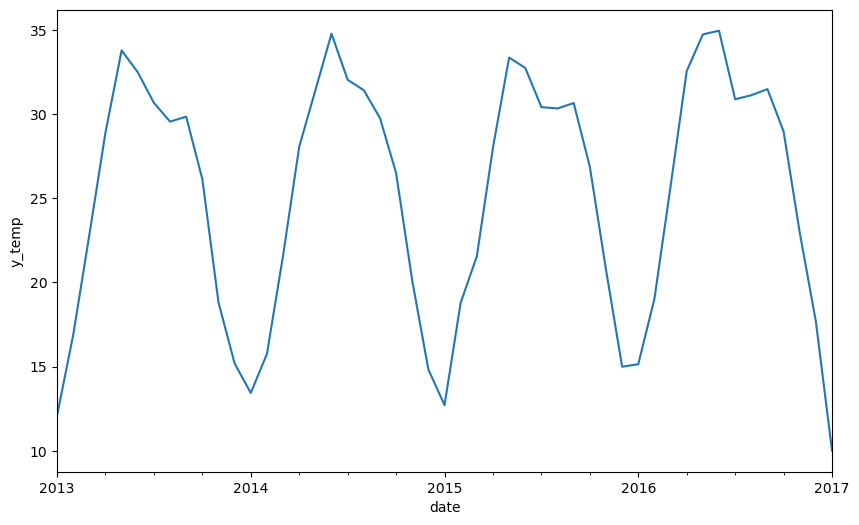

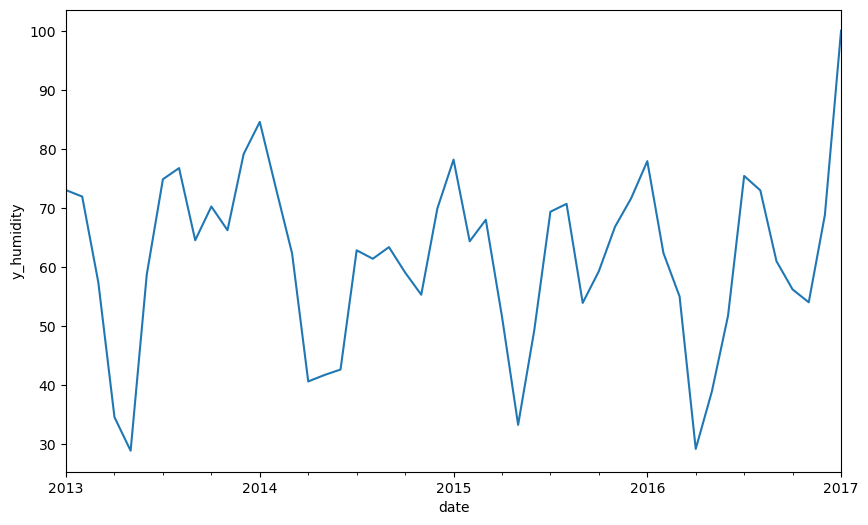

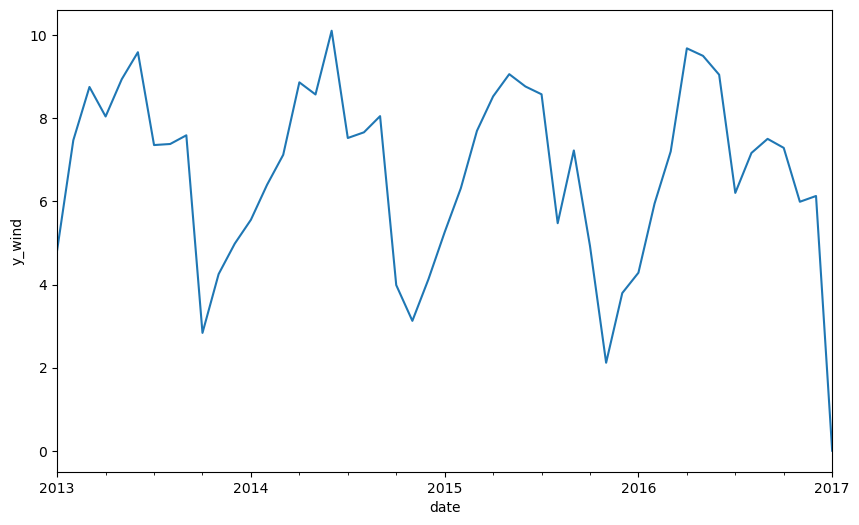

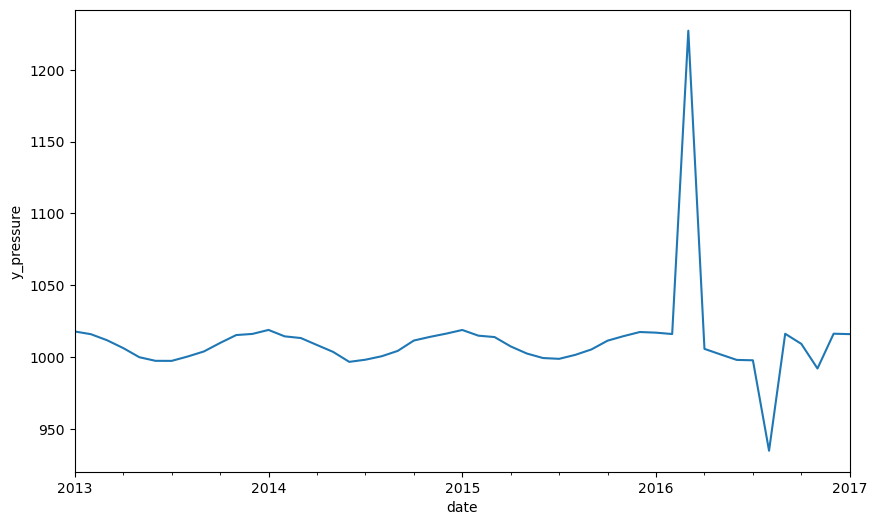

In [23]:
values = [y_temp,y_humidity,y_wind,y_pressure]
names = ['y_temp','y_humidity','y_wind','y_pressure']

for val,name in zip(values ,names) :
    val.plot(figsize=(10,6))
    plt.ylabel(name)
    plt.show()

we can see the pattern in the y_temp , y_humedity , y_wind variable. but in the y_pressure variable we see the pattern only from 2013 to 2015.

#### 6.plot the decomposition graph of Each y variable

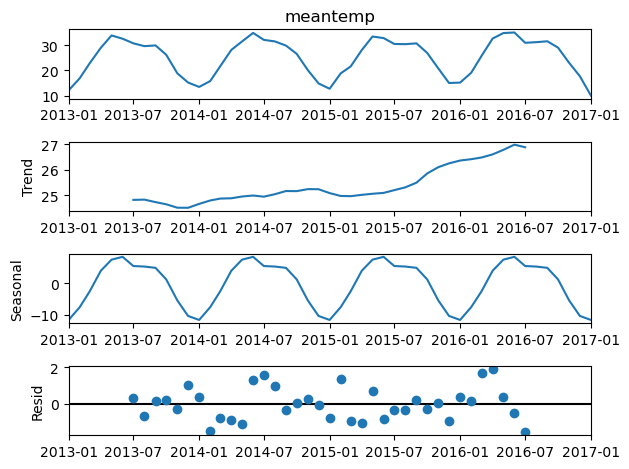

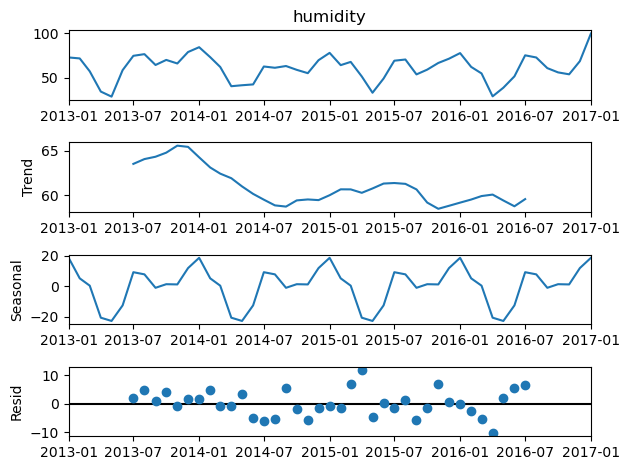

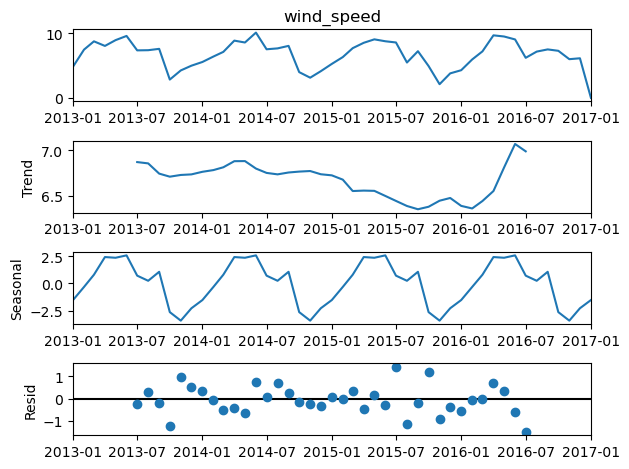

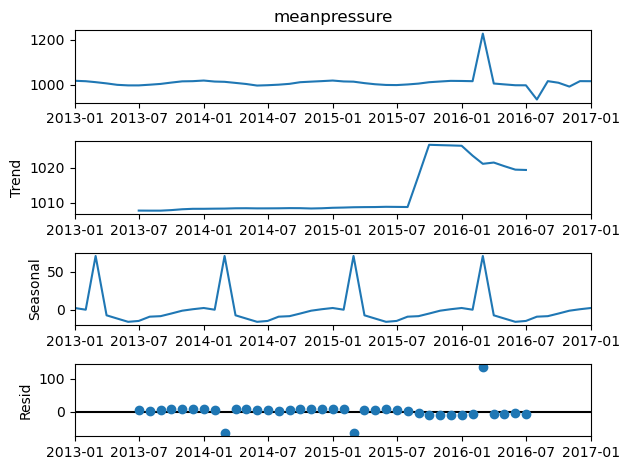

In [24]:
values = [y_temp,y_humidity,y_wind,y_pressure]

for val in values :
    decomposition = sm.tsa.seasonal_decompose(val)
    decomposition.plot()
    plt.show()
    print('\n\n\n')

we can clearly see the seasonal component in each variable (in case y_pressure from 2013 - 2015). for each 12 month the patten is repeating.

#### 6.Modify the y_pressure variable

In [25]:
# limit the data upto 2016
df_pressure = df_pressure.loc[:'2015-12-31']
df_pressure.tail()

,meanpressure
date,
2015-12-27,1020.625
2015-12-28,1020.875
2015-12-29,1018.125
2015-12-30,1017.500
2015-12-31,1020.500


In [26]:
#create y_pressure variable
y_pressure = df_pressure['meanpressure'].resample('MS').mean()
print(y_pressure.shape)

(36,)


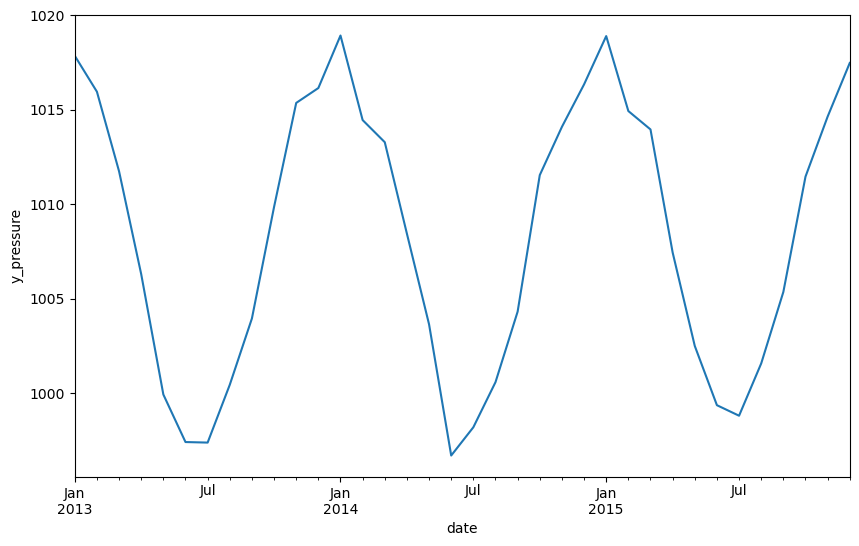

In [27]:
#Plot the y_pressure variable
y_pressure.plot(figsize=(10,6))
plt.ylabel('y_pressure')
plt.show()

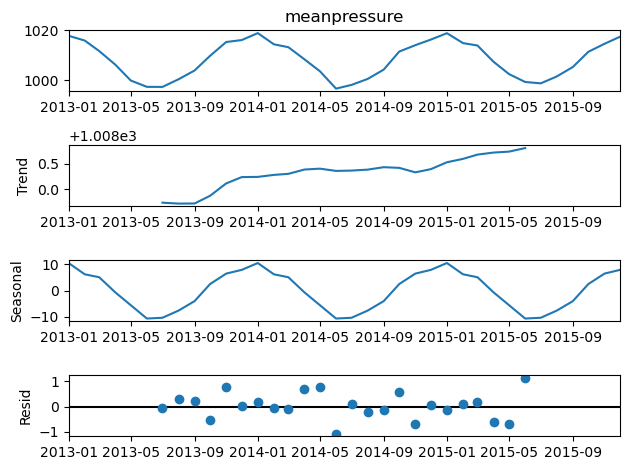

In [28]:
decomposition = sm.tsa.seasonal_decompose(y_pressure)
decomposition.plot()
plt.show()

now we can se the seasonality in the y_pressure variable also

#### 6.Train - Test split for training and validation sets.

In [29]:
y_temp_train = y_temp.loc[:'2015-12-31']
y_humidity_train = y_humidity.loc[:'2015-12-31']
y_wind_train = y_wind.loc[:'2015-12-31']
y_pressure_train = y_pressure.loc[:'2014-12-31']

In [30]:
print(y_temp_train.shape)
print(y_humidity_train.shape)
print(y_wind_train.shape)
print(y_pressure_train.shape)

(36,)
(36,)
(36,)
(24,)


In [31]:
y_temp_train.tail()

date
2015-08-01    30.330789
2015-09-01    30.650000
2015-10-01    26.865207
2015-11-01    20.754167
2015-12-01    14.989631
Freq: MS, Name: meantemp, dtype: float64

In [32]:
y_temp_test = y_temp.loc['2016-01-01':]
y_humidity_test = y_humidity.loc['2016-01-01':]
y_wind_test = y_wind.loc['2016-01-01':]
y_pressure_test = y_pressure.loc['2015-01-01':]

In [33]:
print(y_temp_test.shape)
print(y_humidity_test.shape)
print(y_wind_test.shape)
print(y_pressure_test.shape)

(13,)
(13,)
(13,)
(12,)


In [34]:
y_temp_test.head()

date
2016-01-01    15.139363
2016-02-01    19.025676
2016-03-01    25.701075
2016-04-01    32.550029
2016-05-01    34.728726
Freq: MS, Name: meantemp, dtype: float64

**Conclussion :** 

as we can see the seasonality in each variable therefore we will try Holts_winter model and SARIMA model.

### Model Building

#### 1.Plot the train-test data

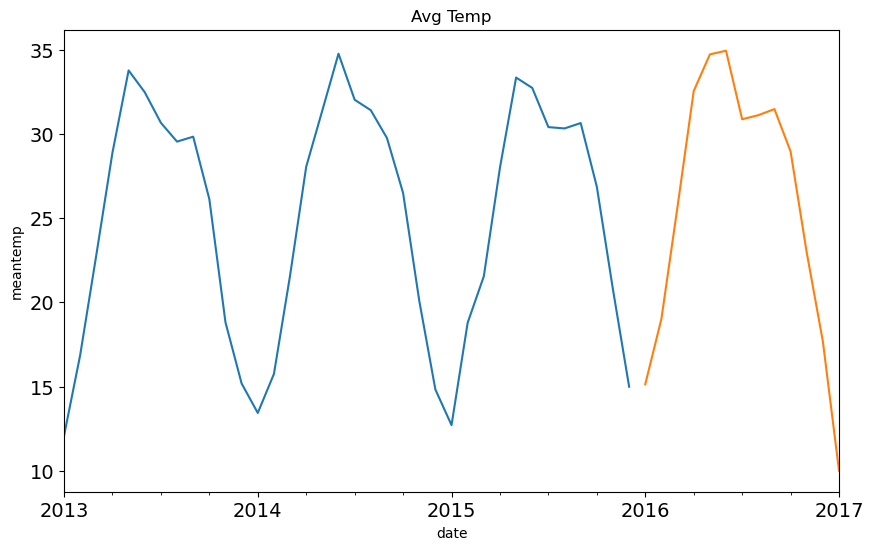

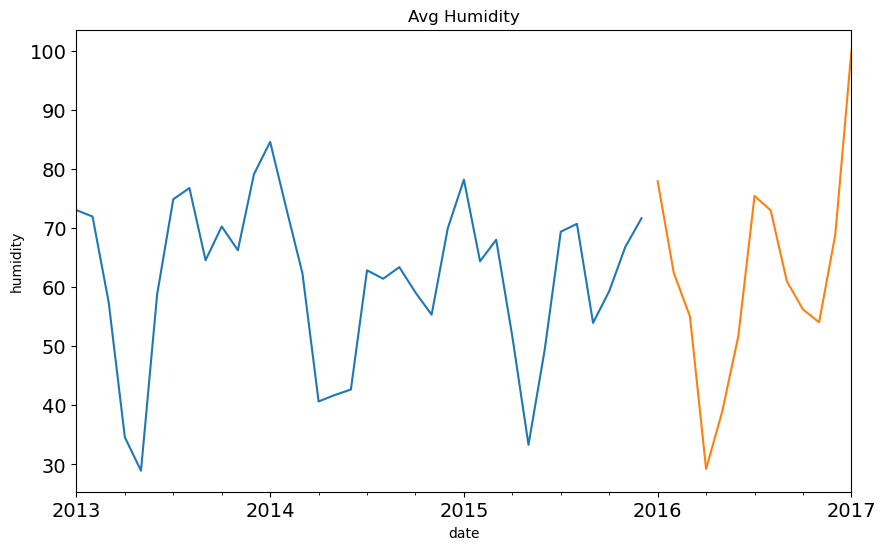

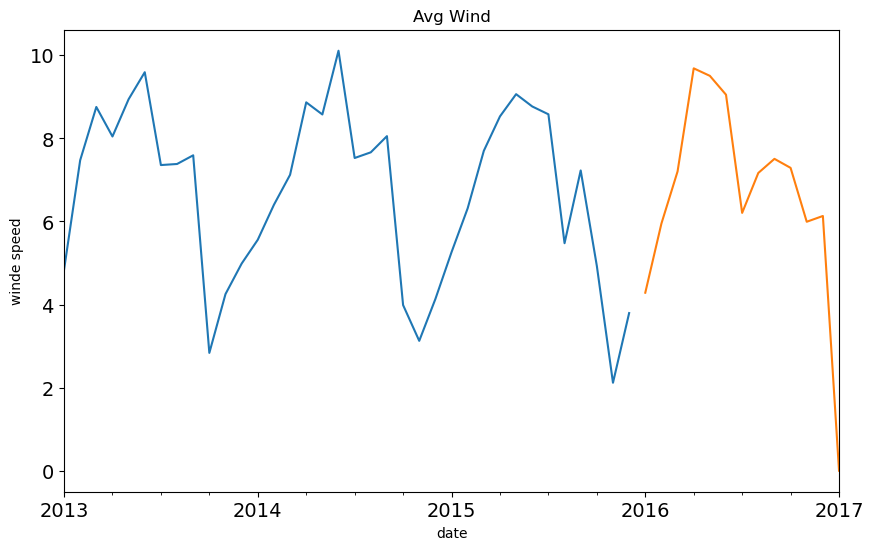

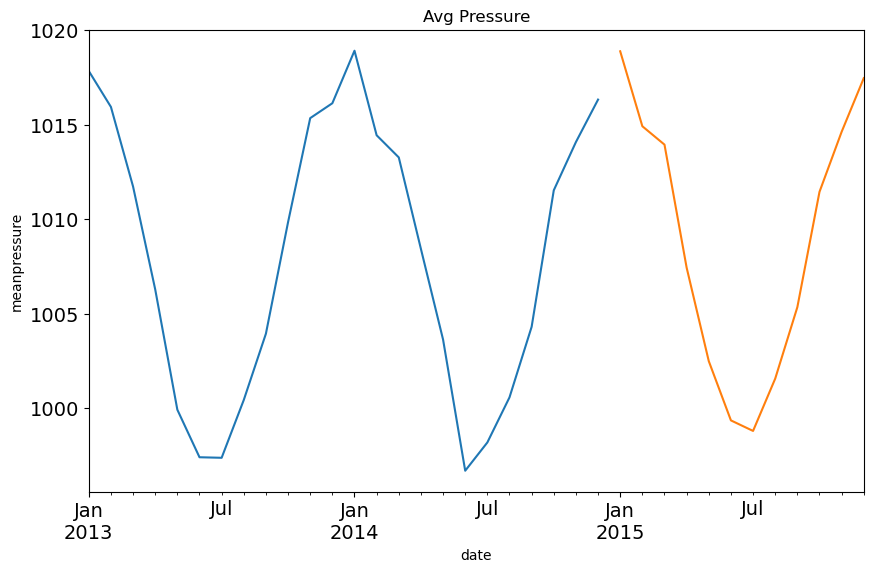

In [35]:
train_values = [y_temp_train,y_humidity_train,y_wind_train,y_pressure_train]
test_values = [y_temp_test,y_humidity_test,y_wind_test,y_pressure_test]
title_names = ['Avg Temp' , 'Avg Humidity' , 'Avg Wind' , 'Avg Pressure']
y_names = ['meantemp', 'humidity' ,'winde speed' , 'meanpressure']


for train ,test ,title ,y_lab in zip(train_values , test_values , title_names , y_names) :
    train.plot(figsize = (10,6) , title = title , fontsize = 14)
    test.plot(figsize = (10,6) , title = title , fontsize = 14)
    plt.ylabel(y_lab)
    plt.show()

#### 2. Holt_winter Model

**For Temp variable**

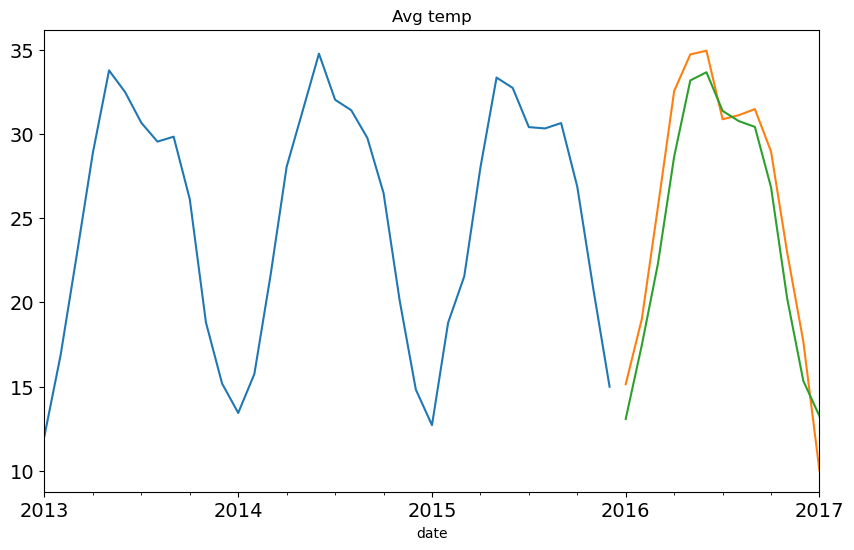

In [36]:
model_temp_df = y_temp_test.copy()

fit_model_temp = ExponentialSmoothing(y_temp_train ,
                          seasonal_periods=12,
                          trend= 'add',
                          seasonal = 'add').fit()

model_temp_df['predicted'] = fit_model_temp.forecast(steps=len(y_temp_test))

y_temp_train.plot(figsize = (10,6) ,title = 'Avg temp' ,fontsize = 14)
y_temp_test.plot(figsize= (10,6) ,title = 'Avg temp' ,fontsize = 14)
model_temp_df['predicted'].plot(figsize = (10,6) ,title = 'Avg temp' ,fontsize = 14)
plt.show()

In [37]:
# Evaluation

range_train = max(y_temp_train) - min(y_temp_train)
print('range of training data :',range_train)
rmse = mean_squared_error(y_temp_test, model_temp_df['predicted'],squared=False)
print('rmse:',rmse)

range of training data : 22.69606374807988
rmse: 2.265293612857406


**For Humidity variable**

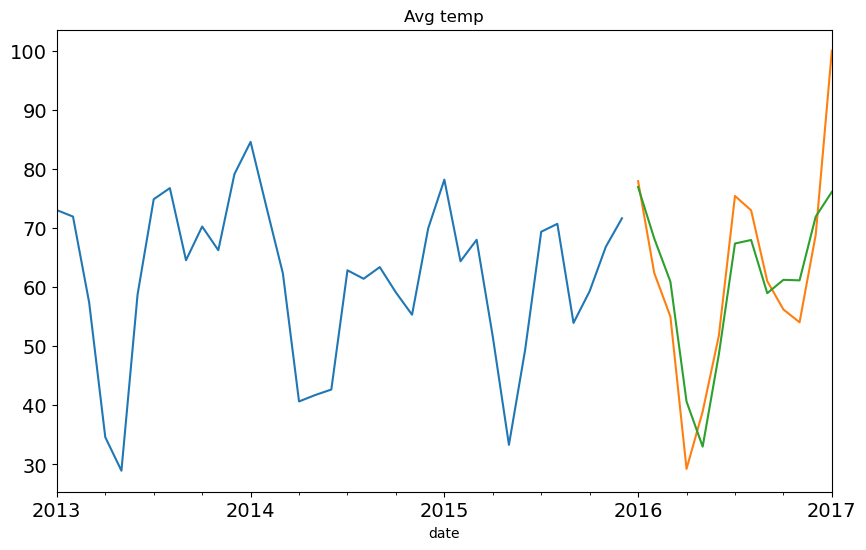

In [38]:
model_humidity_df = y_humidity_test.copy()

fit_model_humidity = ExponentialSmoothing(y_humidity_train ,
                          seasonal_periods=12,
                          trend= 'add',
                          seasonal = 'add').fit()

model_humidity_df['predicted'] = fit_model_humidity.forecast(steps=len(y_humidity_test))

y_humidity_train.plot(figsize = (10,6) ,title = 'Avg temp' ,fontsize = 14)
y_humidity_test.plot(figsize= (10,6) ,title = 'Avg temp' ,fontsize = 14)
model_humidity_df['predicted'].plot(figsize = (10,6) ,title = 'Avg temp' ,fontsize = 14)
plt.show()

In [39]:
# Evaluation

range_train = max(y_humidity_train) - min(y_humidity_train)
print('range of training data :',range_train)
rmse = mean_squared_error(y_humidity_test, model_humidity_df['predicted'],squared=False)
print('rmse:',rmse)

range of training data : 55.63433179723503
rmse: 8.74782147351695


**For Wind variable**

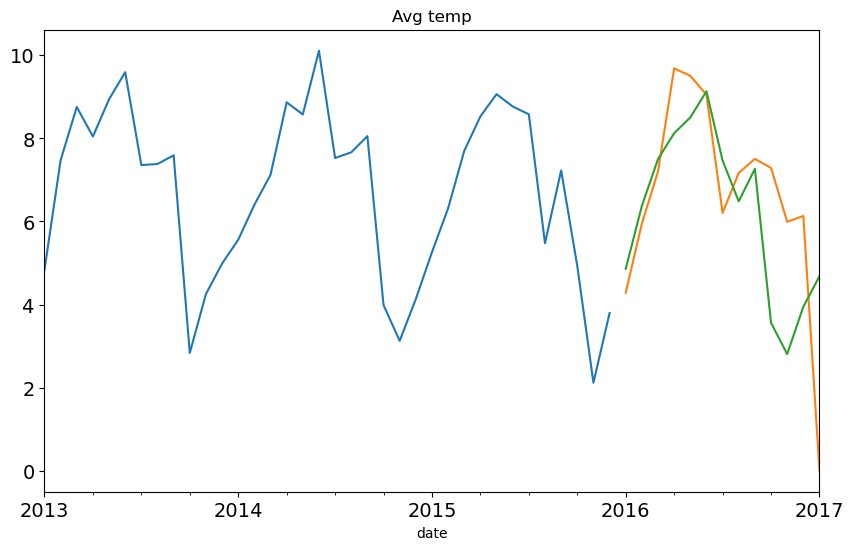

In [40]:
model_wind_df = y_wind_test.copy()

fit_model_wind = ExponentialSmoothing(y_wind_train ,
                          seasonal_periods=12,
                          trend= 'add',
                          seasonal = 'add').fit()

model_wind_df['predicted'] = fit_model_wind.forecast(steps=len(y_wind_test))

y_wind_train.plot(figsize = (10,6) ,title = 'Avg temp' ,fontsize = 14)
y_wind_test.plot(figsize= (10,6) ,title = 'Avg temp' ,fontsize = 14)
model_wind_df['predicted'].plot(figsize = (10,6) ,title = 'Avg temp' ,fontsize = 14)
plt.show()

In [41]:
# Evaluation

range_train = max(y_wind_train) - min(y_wind_train)
print('range of training data :',range_train)
rmse = mean_squared_error(y_wind_test, model_wind_df['predicted'],squared=False)
print('rmse:',rmse)

range of training data : 7.99375
rmse: 2.0925292427537574


**For Pressure variable**

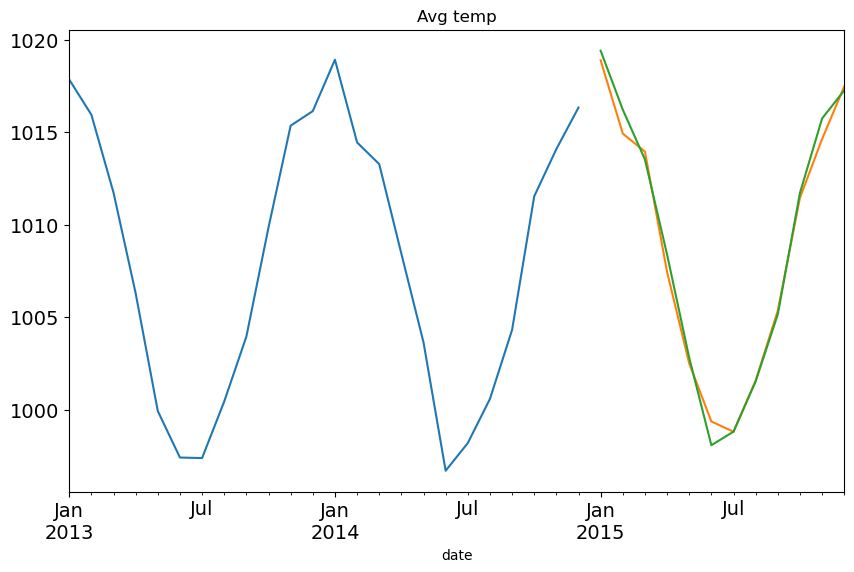

In [42]:
model_pressure_df = y_pressure_test.copy()

fit_model_pressure = ExponentialSmoothing(y_pressure_train ,
                          seasonal_periods=12,
                          trend= 'add',
                          seasonal = 'add').fit()

model_pressure_df['predicted'] = fit_model_pressure.forecast(steps=len(y_pressure_test))

y_pressure_train.plot(figsize = (10,6) ,title = 'Avg temp' ,fontsize = 14)
y_pressure_test.plot(figsize= (10,6) ,title = 'Avg temp' ,fontsize = 14)
model_pressure_df['predicted'].plot(figsize = (10,6) ,title = 'Avg temp' ,fontsize = 14)
plt.show()

In [43]:
# Evaluation

range_train = max(y_pressure_train) - min(y_pressure_train)
print('range of training data :',range_train)
rmse = mean_squared_error(y_pressure_test, model_pressure_df['predicted'],squared=False)
print('rmse:',rmse)

range of training data : 22.224097542242816
rmse: 0.7156873151935343


**Evaluation (RMSE) Conclusion :**

    1.Temp : 2.265 
    
    2.Humidity : 8.748
    
    3.Wind : 2.093
    
    4.Pressure : 0.716

#### 3.SARIMA model

**For Temp variable**

In [44]:
# get best value for p,d,q,P,D,Q with auto_arima() function

model = pm.auto_arima(y_temp,
                     start_p=0 , max_p=3 , start_P=0 ,max_P=3 ,
                     start_q=0 , max_q=3 , start_Q=0 , max_Q=3 ,
                     d= None , max_d=2 , D=None , max_D=2 ,
                     max_order=10 , seasonal= True , m = 12 ,
                     information_criterion='aic' , test= 'adf' ,
                     trace= False, random_state=42
                     )

In [45]:
#model best parameters
model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (0, 1, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 1, 0, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [46]:
#Fit the model
model_temp = SARIMAX(y_temp ,
                     order= (0,1,1) ,
                     seasonal_order=(1,1,0,12)).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63048D+00    |proj g|=  1.61792D-01

At iterate    5    f=  1.47713D+00    |proj g|=  4.54553D-02

At iterate   10    f=  1.46999D+00    |proj g|=  5.27696D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     16      1     0     0   3.475D-06   1.470D+00
  F =   1.4699792849576185     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


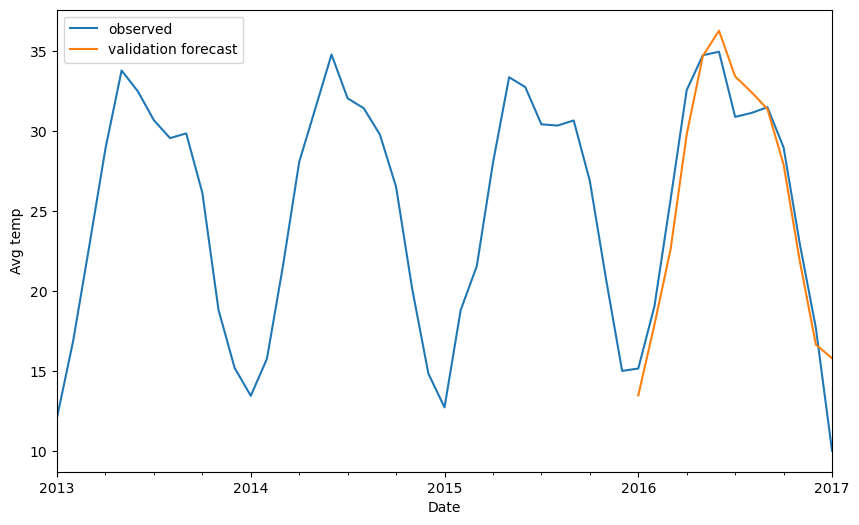

In [47]:
#prediction

pred = model_temp.get_prediction(start = pd.to_datetime('2016-01-01'))
plt.figure(figsize = (10,6))
ax = y_temp['2013':].plot(label = 'observed')
pred.predicted_mean.plot(ax= ax , label = 'validation forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Avg temp')
plt.legend()
plt.show()

In [48]:
#Evaluation

y_pred = pred.predicted_mean
y_test = y_temp_test

rmse = mean_squared_error(y_test, y_pred,squared=False)
print('rmse:',rmse)

rmse: 2.2896069426640153


**For Humidity Variable**

In [49]:
# get best value for p,d,q,P,D,Q with auto_arima() function

model = pm.auto_arima(y_humidity,
                     start_p=0 , max_p=3 , start_P=0 ,max_P=3 ,
                     start_q=0 , max_q=3 , start_Q=0 , max_Q=3 ,
                     d= None , max_d=2 , D=None , max_D=2 ,
                     max_order=10 , seasonal= True , m = 12 ,
                     information_criterion='aic' , test= 'adf' ,
                     trace= False, random_state=42
                     )

In [50]:
#model best parameters
model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (3, 2, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 1, 0, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [51]:
#Fit the model
model_humidity = SARIMAX(y_humidity,
                     order= (3,2,1) ,
                     seasonal_order=(1,1,0,12)).fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.72759D+00    |proj g|=  8.51177D-02

At iterate    5    f=  2.66142D+00    |proj g|=  4.13907D-02

At iterate   10    f=  2.63796D+00    |proj g|=  4.45205D-04

At iterate   15    f=  2.63776D+00    |proj g|=  4.71280D-03

At iterate   20    f=  2.63747D+00    |proj g|=  2.36916D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     31      1     0     0   4.243D-06   2.637D+00
  F =   2.6374709526042848     

CONVERG

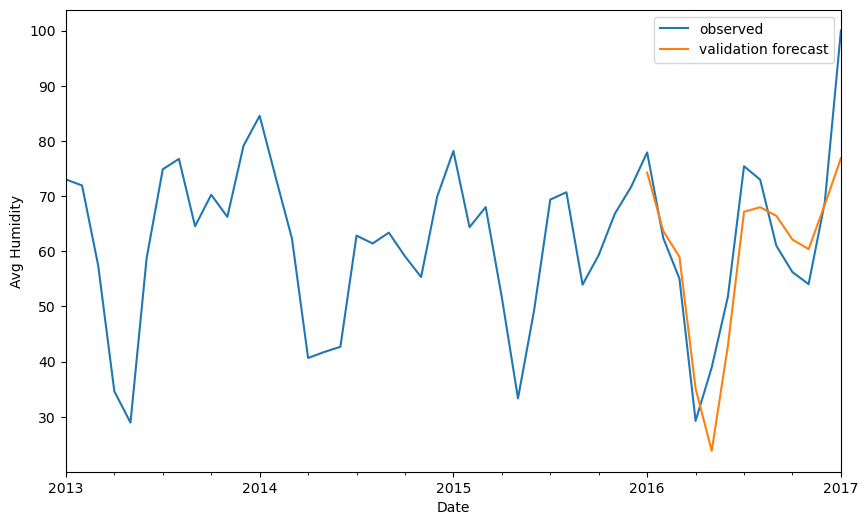

In [52]:
#prediction

pred = model_humidity.get_prediction(start = pd.to_datetime('2016-01-01'))
plt.figure(figsize = (10,6))
ax = y_humidity['2013':].plot(label = 'observed')
pred.predicted_mean.plot(ax= ax , label = 'validation forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Avg Humidity')
plt.legend()
plt.show()

In [53]:
#Evaluation

y_pred = pred.predicted_mean
y_test = y_humidity_test

rmse = mean_squared_error(y_test, y_pred,squared=False)
print('rmse:',rmse)

rmse: 9.22004681534868


**For Wind Variable**

In [54]:
# get best value for p,d,q,P,D,Q with auto_arima() function

model = pm.auto_arima(y_wind ,
                     start_p=0 , max_p=3 , start_P=0 ,max_P=3 ,
                     start_q=0 , max_q=3 , start_Q=0 , max_Q=3 ,
                     d= None , max_d=2 , D=None , max_D=2 ,
                     max_order=10 , seasonal= True , m = 12 ,
                     information_criterion='aic' , test= 'adf' ,
                     trace= False, random_state=42
                     )

In [55]:
#model best parameters
model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 0, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 0, 0, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [56]:
#Fit the model
model_wind = SARIMAX(y_wind,
                     order= (1,0,0) ,
                     seasonal_order=(1,0,0,12)).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37238D+00    |proj g|=  1.29264D-01

At iterate    5    f=  2.00488D+00    |proj g|=  1.21226D-01

At iterate   10    f=  1.96014D+00    |proj g|=  2.52864D-02

At iterate   15    f=  1.95852D+00    |proj g|=  2.21700D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     25      1     0     0   8.593D-07   1.959D+00
  F =   1.9585236191994293     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


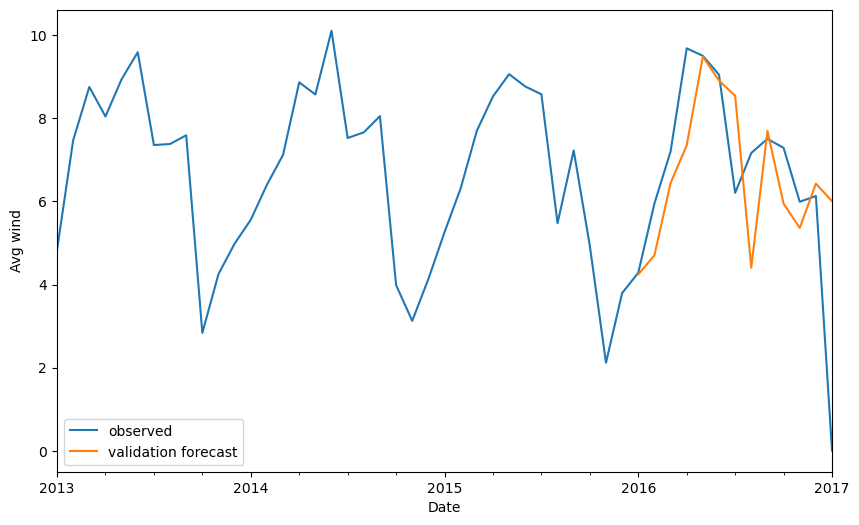

In [57]:
#prediction

pred = model_wind.get_prediction(start = pd.to_datetime('2016-01-01'))
plt.figure(figsize = (10,6))
ax = y_wind['2013':].plot(label = 'observed')
pred.predicted_mean.plot(ax= ax , label = 'validation forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Avg wind')
plt.legend()
plt.show()

In [58]:
#Evaluation

y_pred = pred.predicted_mean
y_test = y_wind_test

rmse = mean_squared_error(y_test, y_pred,squared=False)
print('rmse:',rmse)

rmse: 2.13227867240283


**For Pressure Variable**

In [59]:
# get best value for p,d,q,P,D,Q with auto_arima() function

model = pm.auto_arima(y_pressure,
                     start_p=0 , max_p=3 , start_P=0 ,max_P=3 ,
                     start_q=0 , max_q=3 , start_Q=0 , max_Q=3 ,
                     d= None , max_d=2 , D=None , max_D=2 ,
                     max_order=10 , seasonal= True , m = 12 ,
                     information_criterion='aic' , test= 'adf' ,
                     trace= False, random_state=42
                     )

In [60]:
#model best parameters
model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 1, 0, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [61]:
#Fit the model
model_pressure = SARIMAX(y_pressure,
                     order= (1,1,0) ,
                     seasonal_order=(1,1,0,12)).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13337D+00    |proj g|=  1.22391D-01

At iterate    5    f=  1.08375D+00    |proj g|=  1.93565D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   1.912D-06   1.084D+00
  F =   1.0837361721635945     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


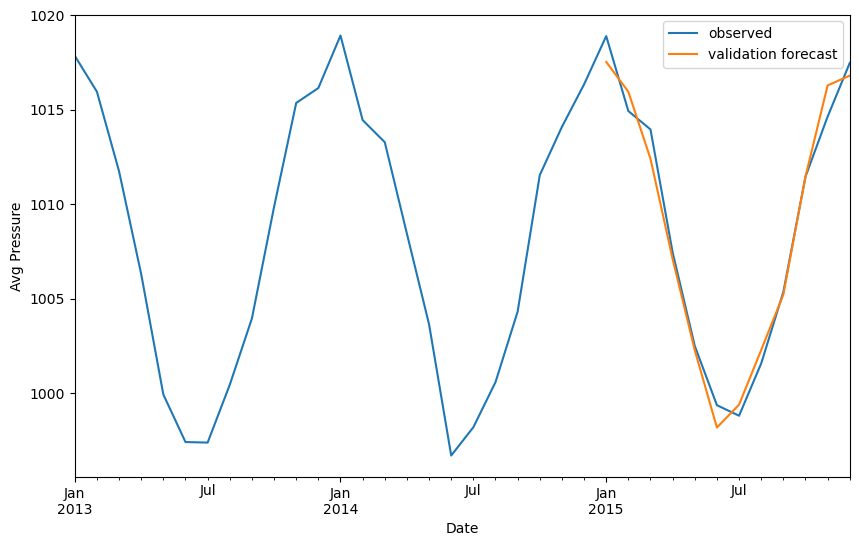

In [62]:
#prediction

pred = model_pressure.get_prediction(start = pd.to_datetime('2015-01-01'))
plt.figure(figsize = (10,6))
ax = y_pressure['2013':].plot(label = 'observed')
pred.predicted_mean.plot(ax= ax , label = 'validation forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Avg Pressure')
plt.legend()
plt.show()

In [63]:
#Evaluation

y_pred = pred.predicted_mean
y_test = y_pressure_test

rmse = mean_squared_error(y_test, y_pred,squared=False)
print('rmse:',rmse)

rmse: 0.9546252699861278


**Evaluation (RMSE) Conclusion via SARIMAX:**

    1.Temp : 2.29
    
    2.Humidity : 9.22
    
    3.Wind : 2.13
    
    4.Pressure : 0.95

In [64]:
Eval = pd.DataFrame()
Eval['Holt Winter RMSE'] = [2.27,8.75,2.09,0.72]
Eval['SARIMAX RMSE'] = [2.29,9.22,2.13,0.95]
Eval.index = ['Temp' , 'Humidity' ,'Wind' , 'Pressure']

Eval

,Holt Winter RMSE,SARIMAX RMSE
Temp,2.27,2.29
Humidity,8.75,9.22
Wind,2.09,2.13
Pressure,0.72,0.95


**Conclussion**

For all the variable we will choose the Holt_winter models.becasue of lower RMSE . 

### PreProccess of the Test data

#### 1 .Load the test data

In [65]:
df_test = pd.read_csv('DailyDelhiClimateTest.csv',header = 0)
df_test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [66]:
df_test.tail()

,date,meantemp,humidity,wind_speed,meanpressure
109,2017-04-20,34.500,27.500000,5.562500,998.625000
110,2017-04-21,34.250,39.375000,6.962500,999.875000
111,2017-04-22,32.900,40.900000,8.890000,1001.600000
112,2017-04-23,32.875,27.500000,9.962500,1002.125000
113,2017-04-24,32.000,27.142857,12.157143,1004.142857


In [67]:
#shape of the test data
df_test.shape

(114, 5)

we have almost 4 month of data for testing from 1st jan 2017 to 24th april 2017. 

In [68]:
#check datatypes of each variable
df_test.dtypes

date             object
meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object

we neet to change the date datatype to datetime

#### 2.check for null values :

In [69]:
df_test.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

no null values in the test data.

#### 3.Change date column datatype to datetime

In [70]:
df_test['date'] = pd.to_datetime(df_test['date'])
df_test['date'].head()

0   2017-01-01
1   2017-01-02
2   2017-01-03
3   2017-01-04
4   2017-01-05
Name: date, dtype: datetime64[ns]

#### 4.set date as an index

In [71]:
df_test.set_index('date',inplace=True)
df_test.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000
2017-01-02,18.500000,77.222222,2.894444,1018.277778
2017-01-03,17.111111,81.888889,4.016667,1018.333333
2017-01-04,18.700000,70.050000,4.545000,1015.700000
2017-01-05,18.388889,74.944444,3.300000,1014.333333


#### 5.create seprate test dataframe for each variable.

In [72]:
test_temp_df =df_test[['meantemp']]
test_humidity_df=df_test[['humidity']]
test_wind_df=df_test[['wind_speed']]
test_pressure_df=df_test[['meanpressure']]

In [73]:
#test_temp_df.head()

#### 6.resample the data

In [74]:
test_temp = test_temp_df['meantemp'].resample('MS').mean()
test_humidity = test_humidity_df['humidity'].resample('MS').mean()
test_wind = test_wind_df['wind_speed'].resample('MS').mean()
test_pressure = test_pressure_df['meanpressure'].resample('MS').mean()

In [75]:
#test_temp

### forecast each variable for 1 year

**For Temp variable**

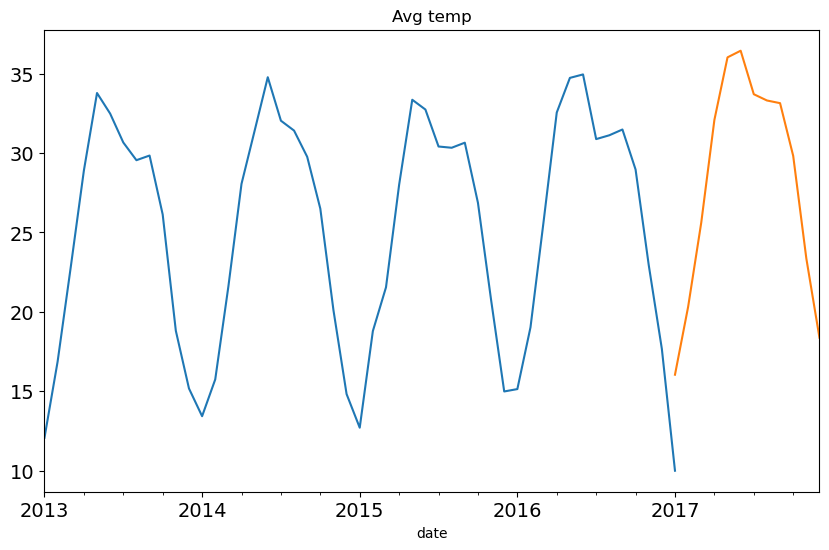

In [76]:
model_temp_df = y_temp_test.copy()

fit_model_temp = ExponentialSmoothing(y_temp[:-1] ,
                          seasonal_periods=12,
                          trend= 'add',
                          seasonal = 'add').fit()

model_temp_df['predicted'] = fit_model_temp.forecast(steps=12)

y_temp.plot(figsize = (10,6) ,title = 'Avg temp' ,fontsize = 14)
model_temp_df['predicted'].plot(figsize = (10,6) ,title = 'Avg temp' ,fontsize = 14)
plt.show()

In [77]:
y_temp_prediction = model_temp_df['predicted']
y_temp_prediction

2017-01-01    16.043868
2017-02-01    20.313166
2017-03-01    25.619364
2017-04-01    32.081867
2017-05-01    36.021142
2017-06-01    36.439268
2017-07-01    33.701057
2017-08-01    33.307015
2017-09-01    33.138465
2017-10-01    29.818419
2017-11-01    23.362133
2017-12-01    18.371568
Freq: MS, dtype: float64

In [78]:
# Evaluate on the Test data 
rmse = mean_squared_error(test_temp ,y_temp_prediction[:4],squared=False)
print(rmse)

1.51736479542961


**For Humidity variable**

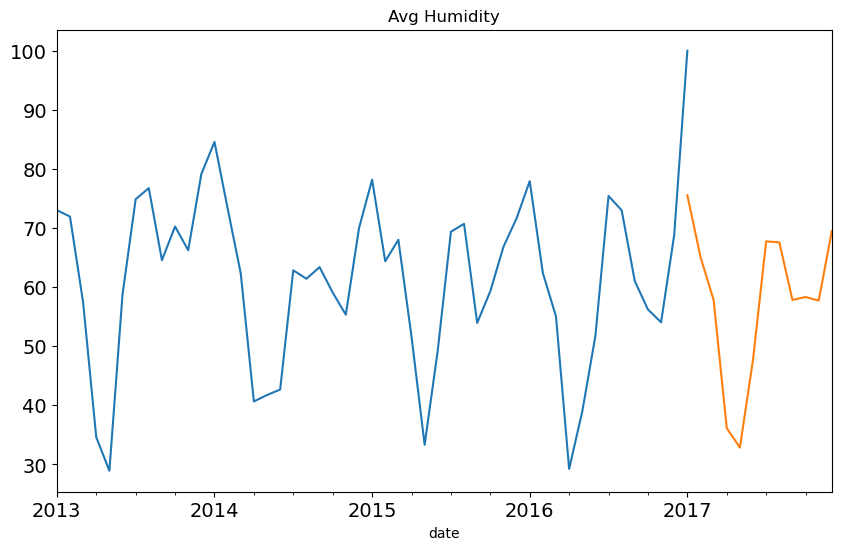

In [79]:
model_humidity_df = y_humidity_test.copy()

fit_model_humidity = ExponentialSmoothing(y_humidity[:-1] ,
                          seasonal_periods=12,
                          trend= 'add',
                          seasonal = 'add').fit()

model_humidity_df['predicted'] = fit_model_humidity.forecast(steps=12)

y_humidity.plot(figsize = (10,6) ,title = 'Avg Humidity' ,fontsize = 14)
model_humidity_df['predicted'].plot(figsize = (10,6) ,title = 'Avg Humidity' ,fontsize = 14)
plt.show()

In [80]:
y_humidity_prediction = model_humidity_df['predicted']
y_humidity_prediction

2017-01-01    75.543311
2017-02-01    65.121572
2017-03-01    57.810812
2017-04-01    36.148894
2017-05-01    32.852311
2017-06-01    47.741059
2017-07-01    67.743792
2017-08-01    67.582230
2017-09-01    57.836964
2017-10-01    58.333054
2017-11-01    57.726274
2017-12-01    69.504654
Freq: MS, dtype: float64

In [82]:
# Evaluate on the Test data 
rmse = mean_squared_error(test_humidity ,y_humidity_prediction[:4],squared=False)
print(rmse)

5.75064782788192


**For Wind variable**

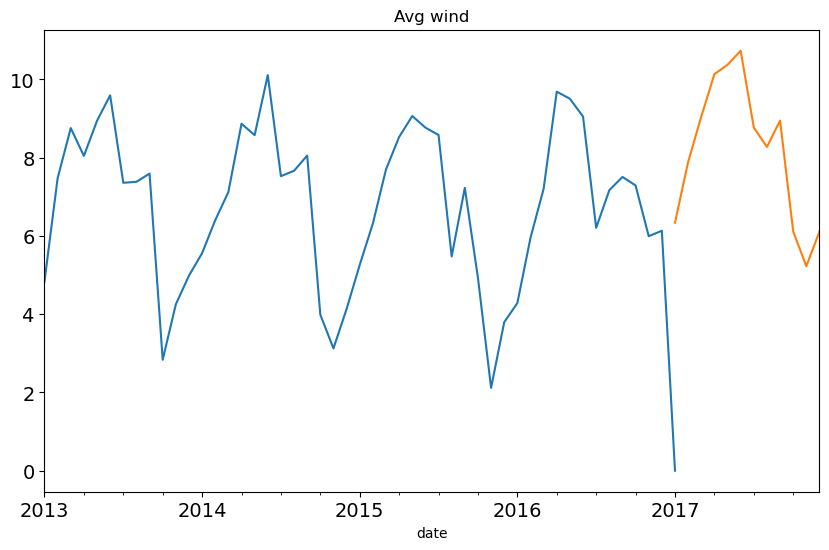

In [83]:
model_wind_df = y_wind_test.copy()

fit_model_wind = ExponentialSmoothing(y_wind[:-1] ,
                          seasonal_periods=12,
                          trend= 'add',
                          seasonal = 'add').fit()

model_wind_df['predicted'] = fit_model_wind.forecast(steps=12)

y_wind.plot(figsize = (10,6) ,title = 'Avg wind' ,fontsize = 14)
model_wind_df['predicted'].plot(figsize = (10,6) ,title = 'Avg wind' ,fontsize = 14)
plt.show()

In [84]:
y_wind_prediction = model_wind_df['predicted']
y_wind_prediction

2017-01-01     6.337782
2017-02-01     7.888935
2017-03-01     9.049408
2017-04-01    10.135832
2017-05-01    10.375472
2017-06-01    10.734153
2017-07-01     8.771527
2017-08-01     8.276403
2017-09-01     8.948845
2017-10-01     6.114060
2017-11-01     5.225191
2017-12-01     6.114522
Freq: MS, dtype: float64

In [85]:
# Evaluate on the Test data 
rmse = mean_squared_error(test_wind ,y_wind_prediction[:4],squared=False)
print(rmse)

0.6758533697889096


**For Temp variable**

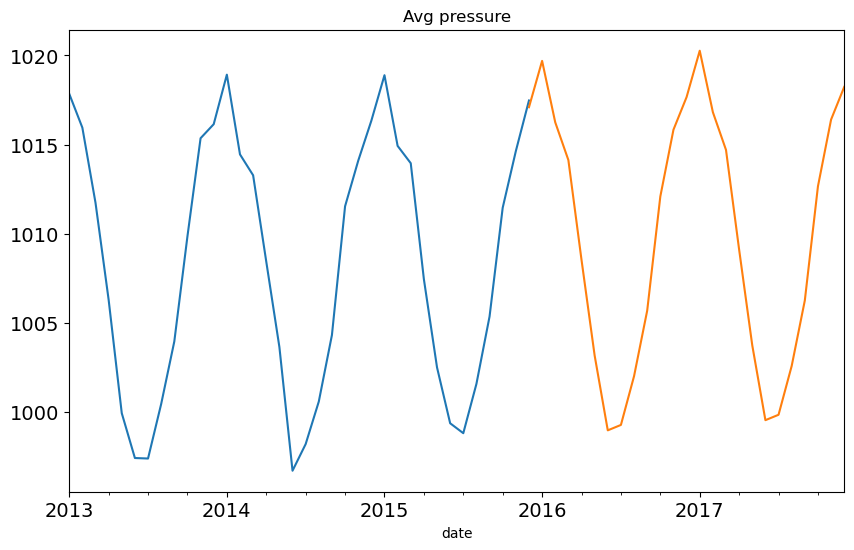

In [86]:
model_pressure_df = y_pressure_test.copy()

fit_model_pressure = ExponentialSmoothing(y_pressure[:-1] ,
                          seasonal_periods=12,
                          trend= 'add',
                          seasonal = 'add').fit()

model_pressure_df['predicted'] = fit_model_pressure.forecast(steps=25)

y_pressure.plot(figsize = (10,6) ,title = 'Avg pressure' ,fontsize = 14)
model_pressure_df['predicted'].plot(figsize = (10,6) ,title = 'Avg pressure' ,fontsize = 14)
plt.show()

In [87]:
y_pressure_prediction = model_pressure_df['predicted']['2017-01-01':]
y_pressure_prediction

2017-01-01    1020.263360
2017-02-01    1016.816321
2017-03-01    1014.697158
2017-04-01    1009.099305
2017-05-01    1003.729232
2017-06-01     999.532196
2017-07-01     999.835407
2017-08-01    1002.572840
2017-09-01    1006.247859
2017-10-01    1012.655753
2017-11-01    1016.400856
2017-12-01    1018.233735
Freq: MS, dtype: float64

In [88]:
# Evaluate on the Test data 
rmse = mean_squared_error(test_pressure ,y_pressure_prediction[:4],squared=False)
print(rmse)

17.043464846172792


### Create dataframe for forecast and export

In [89]:
#create dataframe

forcast_2018 = pd.DataFrame()
forcast_2018['meantemp']=y_temp_prediction
forcast_2018['humidity']=y_humidity_prediction
forcast_2018['wind_speed']=y_wind_prediction
forcast_2018['meanpressure']=y_pressure_prediction

forcast_2018.index =['2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
                     '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
                     '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01']

In [90]:
forcast_2018

,meantemp,humidity,wind_speed,meanpressure
2017-01-01,16.043868,75.543311,6.337782,1020.263360
2017-02-01,20.313166,65.121572,7.888935,1016.816321
2017-03-01,25.619364,57.810812,9.049408,1014.697158
2017-04-01,32.081867,36.148894,10.135832,1009.099305
2017-05-01,36.021142,32.852311,10.375472,1003.729232
2017-06-01,36.439268,47.741059,10.734153,999.532196
2017-07-01,33.701057,67.743792,8.771527,999.835407
2017-08-01,33.307015,67.582230,8.276403,1002.572840
2017-09-01,33.138465,57.836964,8.948845,1006.247859
2017-10-01,29.818419,58.333054,6.114060,1012.655753


In [91]:
#Export dataframe

#forcast_2018.to_csv('forcast_2018.csv',index=True)